In [92]:
import pandas as pd
import wikipedia
import datetime
import requests
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import json

In [15]:
%matplotlib inline

On wikipedia, go to the event's page (i.e. [Santa Fe](https://en.wikipedia.org/wiki/Santa_Fe_High_School_shooting)  ) and go to the `View History ` link at the up-right corner of the page. You can click on oldest to see the oldest edit of the wiki page (including the article creation date). 

For unexpected events, the wikipedia page is created on the same day with the event, while for expected events [US elections 2018](https://en.wikipedia.org/wiki/2018_United_States_elections), the wiki page is created way in advance (in this case 2013).

Another kind of unexpected event, that is a mix of both is the death of one famous person: the wikipedia page already existed but it's probably expected that the views count incresed by much on the date of death. Out of curiousity and because the purpose of this is just to show the feasibility of obtaining such a graph, I chose to make the central event of this graph the death of Stan Lee. 

First let's track the view counts of the individual page only

In [3]:
def getUserActivity(article, granularity, start, end, project ="en.wikipedia.org",
                    access="all-access", agent="user",dateformat="iso"):
    """
    Method to obtain user activity of a given page for a given period of time
    article: name of the wikiipedia article
    granularity: time granularity of activity, either 'monthly' or 'daily'
    start: start date of the research as Datetime.datetime object
    end: end date of the research as Datetime.datetime object
    project: If you want to filter by project, use the domain of any Wikimedia project (by default en.wikipedia.org)
    access: If you want to filter by access method, use one of desktop, mobile-app or mobile-web (by default all-access)
    agent: If you want to filter by agent type, use one of user, bot or spider (by default user).
    dateformat: the dateformat used in result array, can be 'iso','ordinal','datetime'.
    return:
        it return an array of array of the form [ [user_activity_value1, date1], [user_activity_value2, date2]]
    """

    #granularity['monthly','daily']
    #format['iso','ordinal','datetime']
    #Be carefull, for daily granularity left bound date is included, for monthly granularity left bound date is excluded
    
    dstart = start.strftime("%Y%m%d")
    dend = end.strftime("%Y%m%d")
    path = ("https://wikimedia.org/api/rest_v1/metrics/pageviews/per-article/"+project
            +"/"+access+"/"+agent+"/"+article+"/"+granularity+"/"+dstart+"/"+dend)
    r = requests.get(path)
    res = []
    for i in range(len(r.json()['items'])):
        time_label = None
        if granularity == 'daily':
            time_label = (start + datetime.timedelta(days=i))
        else:
            time_label = (start + relativedelta(months=+i))
        if dateformat == 'iso':
            time_label = time_label.isoformat()
        elif dateformat == 'ordinal':
            time_label = time_label.toordinal()
            
        res.append([r.json()['items'][i]['views'],time_label])
    return res

In [4]:
# get first monthly activity
s = datetime.datetime(year=2018,month=1,day=1)
e = datetime.datetime(year=2019,month=1,day=1) # last days of Dec excluded
monthly_view = getUserActivity(article="Stan Lee",granularity="monthly",start=s,end=e,dateformat="iso")

In [5]:
monthly_view

[[292107, '2018-01-01T00:00:00'],
 [516914, '2018-02-01T00:00:00'],
 [489175, '2018-03-01T00:00:00'],
 [486460, '2018-04-01T00:00:00'],
 [720690, '2018-05-01T00:00:00'],
 [300184, '2018-06-01T00:00:00'],
 [363778, '2018-07-01T00:00:00'],
 [294614, '2018-08-01T00:00:00'],
 [271915, '2018-09-01T00:00:00'],
 [274458, '2018-10-01T00:00:00'],
 [6615990, '2018-11-01T00:00:00'],
 [541911, '2018-12-01T00:00:00']]

Text(0.5, 1.0, 'View Counts of Stan Lee wiki article ')

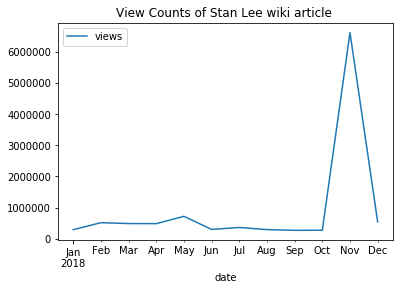

In [30]:
monthly_view_df = pd.DataFrame(monthly_view, columns=['views', 'date'])
monthly_view_df.date = pd.to_datetime(monthly_view_df.date)
monthly_view_df.set_index('date', inplace=True)
monthly_view_df.plot()
plt.title('View Counts of Stan Lee wiki article ')

In [8]:
# get daily activity all throughout november and beginning of december (month he died)
s = datetime.datetime(year=2018,month=11,day=1)
e = datetime.datetime(year=2018,month=12,day=20) 
daily_view = getUserActivity(article="Stan Lee",granularity="daily",start=s,end=e,dateformat="iso")

In [24]:
daily_view_df = pd.DataFrame(daily_view, columns=['views', 'date'])
daily_view_df.date = pd.to_datetime(daily_view_df.date)
daily_view_df.set_index('date', inplace=True)
daily_view_df.head()

,views
date,
2018-11-01,6307
2018-11-02,6281
2018-11-03,6745
2018-11-04,7190
2018-11-05,6086


Text(0.5, 1.0, 'View Counts of Stan Lee wiki article ')

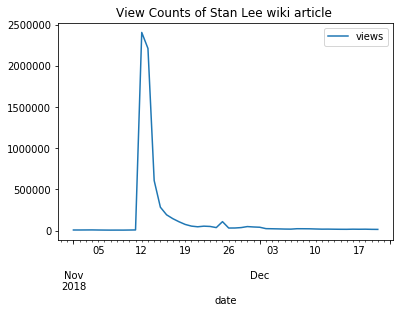

In [29]:
daily_view_df.plot()
plt.title('View Counts of Stan Lee wiki article ')

Note: https://tools.wmflabs.org/pageviews/?project=en.wikipedia.org&platform=all-access&agent=user&start=2018-11-04&end=2018-12-07&pages=Stan_Lee

### So the viewcounts did increase at the date of death, as expected. 
### Did it ALSO increase for neighbouring pages (cascade/heat kernel etc)

A potential approach to build the graph:
* get the article as it was when the event happened (i.e. 12th of Nov) and accept you can't be really precise with that
* do BFS for 2 hops, noting that the 1-hop distance away articles should also be obtained as they were on 12th of Nov (otherwise you might have extra links) -> procedure a bit tricky, need to discuss 

In [31]:
seed = "Stan Lee"

In [36]:
page = wikipedia.page(seed)
links = page.links # note: see the significance of Namespace 0 !

In [38]:
# number of links of the page as is NOW 
len(links)

2018

#### get the page of Stan Lee as it was on 12th of November 2018.
we could use pywikibot. 
Links for later reference (https://pypi.org/project/pywikibot/, https://doc.wikimedia.org/pywikibot/master/, https://www.mediawiki.org/wiki/Manual:Pywikibot/Installation, https://github.com/wikimedia/pywikibot, https://www.wikidata.org/wiki/Wikidata:Pywikibot_-_Python_3_Tutorial/Setting_up_Shop ) 


?? we need wikidata account for that

### Or just make directly a query to the wikimedia API
Inspired from https://stackoverflow.com/questions/34411896/how-to-get-full-wikipedia-revision-history-list-from-some-article

##### parameters explained in https://en.wikipedia.org/w/api.php?action=help&modules=query%2Brevisions

In [51]:
pageTitle = 'Coffee'

In [64]:
url = "https://en.wikipedia.org/w/api.php?action=query&format=json&prop=revisions&rvlimit=5&titles=" + pageTitle
revisions = [] 
response = urllib.request.urlopen(url).read()

In [65]:
response

b'{"continue":{"rvcontinue":"20181209033337|872773524","continue":"||"},"query":{"pages":{"604727":{"pageid":604727,"ns":0,"title":"Coffee","revisions":[{"revid":875147331,"parentid":872917748,"user":"ELApro","timestamp":"2018-12-24T03:41:32Z","comment":"/* External links */linked existing wikiquote article"},{"revid":872917748,"parentid":872774006,"user":"Doorbuster217","timestamp":"2018-12-10T01:33:06Z","comment":"yemen -> modern day yemen"},{"revid":872774006,"parentid":872773870,"user":"Apple juice29","timestamp":"2018-12-09T03:38:45Z","comment":"/* Brewing */"},{"revid":872773870,"parentid":872773773,"user":"Apple juice29","timestamp":"2018-12-09T03:37:13Z","comment":"/* Storage */"},{"revid":872773773,"parentid":872773524,"user":"Apple juice29","timestamp":"2018-12-09T03:36:14Z","comment":"/* Decaffeination */"}]}}}}'

In [77]:
# get a revision precise by date
# rvstart means that edits from [article_creation_time, rvstart] are recovered, ordered in descending date (from rvstart to creation)
url2 = "https://en.wikipedia.org/w/api.php?action=query&format=json&prop=revisions&rvstart=2006-04-18T00:00:00Z&rvlimit=5&titles=" + pageTitle
response_old = urllib.request.urlopen(url2).read()


In [78]:
response_old

b'{"continue":{"rvcontinue":"20060414211051|48472544","continue":"||"},"query":{"pages":{"604727":{"pageid":604727,"ns":0,"title":"Coffee","revisions":[{"revid":48825853,"parentid":48691452,"minor":"","user":"Jojit fb","timestamp":"2006-04-17T10:32:11Z","comment":""},{"revid":48691452,"parentid":48638058,"user":"Chorney","timestamp":"2006-04-16T11:31:42Z","comment":""},{"revid":48638058,"parentid":48638001,"minor":"","user":"Nandesuka","timestamp":"2006-04-16T00:26:04Z","comment":"ref"},{"revid":48638001,"parentid":48474463,"minor":"","user":"Nandesuka","timestamp":"2006-04-16T00:25:37Z","comment":"avoid tangential asides in introductory paragraphs"},{"revid":48474463,"parentid":48472544,"minor":"","user":"Kbh3rd","timestamp":"2006-04-14T21:23:43Z","comment":"Reverted edits by [[Special:Contributions/83.100.188.80|83.100.188.80]] ([[User talk:83.100.188.80|talk]]) to last version by NTK"}]}}}}'

In [81]:
# get a revision precise by date
# that means that edits from [rvend, present] are recovered, ordered in descending date (from present to rvend)
#  note rvlimit limits to the last 5 edits 
url3 = "https://en.wikipedia.org/w/api.php?action=query&format=json&prop=revisions&rvend=2006-04-18T00:00:00Z&rvlimit=5&titles=" + pageTitle
response_old = urllib.request.urlopen(url3).read()



In [83]:
response_old

b'{"continue":{"rvcontinue":"20181209033337|872773524","continue":"||"},"query":{"pages":{"604727":{"pageid":604727,"ns":0,"title":"Coffee","revisions":[{"revid":875147331,"parentid":872917748,"user":"ELApro","timestamp":"2018-12-24T03:41:32Z","comment":"/* External links */linked existing wikiquote article"},{"revid":872917748,"parentid":872774006,"user":"Doorbuster217","timestamp":"2018-12-10T01:33:06Z","comment":"yemen -> modern day yemen"},{"revid":872774006,"parentid":872773870,"user":"Apple juice29","timestamp":"2018-12-09T03:38:45Z","comment":"/* Brewing */"},{"revid":872773870,"parentid":872773773,"user":"Apple juice29","timestamp":"2018-12-09T03:37:13Z","comment":"/* Storage */"},{"revid":872773773,"parentid":872773524,"user":"Apple juice29","timestamp":"2018-12-09T03:36:14Z","comment":"/* Decaffeination */"}]}}}}'

In [87]:
# now get the Stan Lee page as it was on 12th of November, when he died
pageTitle_encoded = 'Stan%20Lee'
url = "https://en.wikipedia.org/w/api.php?action=query&format=json&prop=revisions&rvstart=2018-11-13T00:00:00Z&rvlimit=5&titles=" + pageTitle_encoded
resp_Stan_Lee = urllib.request.urlopen(url).read()

In [89]:
resp_Stan_Lee

b'{"continue":{"rvcontinue":"20181112233346|868557963","continue":"||"},"query":{"pages":{"18598186":{"pageid":18598186,"ns":0,"title":"Stan Lee","revisions":[{"revid":868559267,"parentid":868559093,"minor":"","user":"TheAwesomeHwyh","timestamp":"2018-11-12T23:45:44Z","comment":"Masem, please stop moving the image to the right. It appears too low when on the right."},{"revid":868559093,"parentid":868559048,"minor":"","user":"Knhoj","timestamp":"2018-11-12T23:44:02Z","comment":"Change to correct wikilink on Chris Evans"},{"revid":868559048,"parentid":868558964,"minor":"","user":"Masem","timestamp":"2018-11-12T23:43:44Z","comment":"/* Early career */"},{"revid":868558964,"parentid":868558770,"user":"Masem","timestamp":"2018-11-12T23:43:03Z","comment":"/* Early career */ bit about Signal Corps honors"},{"revid":868558770,"parentid":868557963,"minor":"","user":"TheAwesomeHwyh","timestamp":"2018-11-12T23:41:11Z","comment":"move image back to the left as so it appears properly on desktop."}]

In [93]:
# put the resposonse into json
resp_Stan_Lee_json= json.loads(resp_Stan_Lee.decode('utf-8'))

In [102]:
resp_Stan_Lee_json['query']['pages']['18598186']['revisions']

[{'revid': 868559267,
  'parentid': 868559093,
  'minor': '',
  'user': 'TheAwesomeHwyh',
  'timestamp': '2018-11-12T23:45:44Z',
  'comment': 'Masem, please stop moving the image to the right. It appears too low when on the right.'},
 {'revid': 868559093,
  'parentid': 868559048,
  'minor': '',
  'user': 'Knhoj',
  'timestamp': '2018-11-12T23:44:02Z',
  'comment': 'Change to correct wikilink on Chris Evans'},
 {'revid': 868559048,
  'parentid': 868558964,
  'minor': '',
  'user': 'Masem',
  'timestamp': '2018-11-12T23:43:44Z',
  'comment': '/* Early career */'},
 {'revid': 868558964,
  'parentid': 868558770,
  'user': 'Masem',
  'timestamp': '2018-11-12T23:43:03Z',
  'comment': '/* Early career */ bit about Signal Corps honors'},
 {'revid': 868558770,
  'parentid': 868557963,
  'minor': '',
  'user': 'TheAwesomeHwyh',
  'timestamp': '2018-11-12T23:41:11Z',
  'comment': 'move image back to the left as so it appears properly on desktop.'}]

Now, to get to the page of Stan Lee as it was on the 12th of November, go to 

https://en.wikipedia.org/w/index.php?title=Stan_Lee&oldid=868559267

where oldid is the id of the revid you are interested in. 
Explained [here](https://en.wikipedia.org/wiki/Wikipedia:Revision_id)

### Next: getting the links of that page programatically ??

In [103]:
url = "https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&format=jsonfm&formatversion=2&revids=868558770"
resp_Stan_Lee_12 = urllib.request.urlopen(url).read()


In [104]:
resp_Stan_Lee_12

b'<!DOCTYPE html>\n<html class="client-nojs" lang="en" dir="ltr">\n<head>\n<meta charset="UTF-8"/>\n<title>MediaWiki API result - Wikipedia</title>\n<script>document.documentElement.className = document.documentElement.className.replace( /(^|\\s)client-nojs(\\s|$)/, "$1client-js$2" );</script>\n<script>(window.RLQ=window.RLQ||[]).push(function(){mw.config.set({"wgCanonicalNamespace":"Special","wgCanonicalSpecialPageName":"ApiHelp","wgNamespaceNumber":-1,"wgPageName":"Special:ApiHelp","wgTitle":"ApiHelp","wgCurRevisionId":0,"wgRevisionId":0,"wgArticleId":0,"wgIsArticle":false,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":[],"wgBreakFrames":false,"wgPageContentLanguage":"en","wgPageContentModel":"wikitext","wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgMonthNames

In [114]:
# sanity check that this actually crawls the right page
# now get the Stan Lee page as it was on 10th of November, Before he died
pageTitle_encoded = 'Stan%20Lee'
url = "https://en.wikipedia.org/w/api.php?action=query&format=json&prop=revisions&rvstart=2018-11-11T00:00:00Z&rvlimit=5&titles=" + pageTitle_encoded
resp_Stan_Lee_before_death = urllib.request.urlopen(url).read()

In [115]:
json.loads(resp_Stan_Lee_before_death.decode('utf-8'))

{'continue': {'rvcontinue': '20181020150922|864933438', 'continue': '||'},
 'query': {'pages': {'18598186': {'pageid': 18598186,
    'ns': 0,
    'title': 'Stan Lee',
    'revisions': [{'revid': 867952836,
      'parentid': 867952641,
      'user': 'TavagohCockrell',
      'timestamp': '2018-11-09T01:24:17Z',
      'comment': 'fixed reference erroro'},
     {'revid': 867952641,
      'parentid': 867952538,
      'user': 'TavagohCockrell',
      'timestamp': '2018-11-09T01:22:35Z',
      'comment': 'fixed my error'},
     {'revid': 867952538,
      'parentid': 867951987,
      'user': 'TavagohCockrell',
      'timestamp': '2018-11-09T01:21:39Z',
      'comment': 'added content. hoping not a glitch, will fix if so, sorry!'},
     {'revid': 867951987,
      'parentid': 867873678,
      'user': 'TavagohCockrell',
      'timestamp': '2018-11-09T01:16:57Z',
      'comment': 'fun fact added'},
     {'revid': 867873678,
      'parentid': 864933438,
      'minor': '',
      'user': 'Ser Amantio

In [116]:
url = "https://en.wikipedia.org/w/api.php?action=query&prop=revisions&rvprop=content&format=jsonfm&formatversion=2&revids=867952836"
resp_Stan_Lee_10 = urllib.request.urlopen(url).read()

In [117]:
# Note there is no mention of his death !
resp_Stan_Lee_10

b'<!DOCTYPE html>\n<html class="client-nojs" lang="en" dir="ltr">\n<head>\n<meta charset="UTF-8"/>\n<title>MediaWiki API result - Wikipedia</title>\n<script>document.documentElement.className = document.documentElement.className.replace( /(^|\\s)client-nojs(\\s|$)/, "$1client-js$2" );</script>\n<script>(window.RLQ=window.RLQ||[]).push(function(){mw.config.set({"wgCanonicalNamespace":"Special","wgCanonicalSpecialPageName":"ApiHelp","wgNamespaceNumber":-1,"wgPageName":"Special:ApiHelp","wgTitle":"ApiHelp","wgCurRevisionId":0,"wgRevisionId":0,"wgArticleId":0,"wgIsArticle":false,"wgIsRedirect":false,"wgAction":"view","wgUserName":null,"wgUserGroups":["*"],"wgCategories":[],"wgBreakFrames":false,"wgPageContentLanguage":"en","wgPageContentModel":"wikitext","wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgMonthNames

In [118]:
# Because we cant get the links with the revision id using the wikipedia page, we need to obtain links via the API
# reference here: https://stackoverflow.com/questions/14882571/how-to-get-all-urls-in-a-wikipedia-page 